In [2]:
from math import log10, pi, sqrt

import matplotlib.pyplot as plt
import torch
import torch.distributions as dist


Tensor = torch.Tensor
plt.rcParams["figure.facecolor"] = "w"

In [3]:
def get_meshgrid(resolution, nx, ny, device=None):
    """Constructs lens plane meshgrids with padding for kernel convolution.

    Returns
    -------
    X, Y : torch.Tensor, torch.Tensor
    """
    dx = resolution
    dy = resolution

    # Coordinates at pixel centers
    x = torch.linspace(-1, 1, int(nx), device=device) * (nx - 1) * dx / 2
    y = torch.linspace(-1, 1, int(ny), device=device) * (ny - 1) * dy / 2

    # Note difference to numpy (!)
    Y, X = torch.meshgrid((y, x), indexing='ij')

    return X, Y


# def sample_gp_prior(d2s, sigma):
#     """
#     Samples from N(0, K), where K_ij = k(x_i, x_j) is a radial basis function
#     kernel.
#     """
#     n_pix = int(sqrt(d2s.shape[0]))
#     K = (-d2s / (2 * sigma**2)).exp()
#     return (K @ torch.randn(n_pix**2)).reshape(n_pix, n_pix)

# Old

In [52]:
extent = 10  # degrees
n_pix = 32
resolution = 2 * extent / n_pix
X, Y = get_meshgrid(resolution, n_pix, n_pix)

# Useful global variables
pts = torch.stack([X.flatten(), Y.flatten()])
d2s = ((pts[:, :, None] - pts[:, None, :])**2).sum(0)

d_gc = 8.3  # kpc

## Dark matter

The DM emission from annihilation is proportional to the integral of the density profile squared along the line of sight. For simplicity, here we assume the emission is described by a gamma distribution.

In [5]:
dm_dist = dist.Gamma(0.5, 1 / 5.0)
ps_gc_dist = dist.Gamma(dm_dist.concentration + 1, dm_dist.rate)


def sample_dm_emission(X, Y):
    """
    The DM emission from annihilation is proportional to the integral of the density
    profile squared along the line of sight. For simplicity, here we assume the
    emission is described by a gamma distribution.
    """
    # Parameters chosen by hand
    var = torch.sqrt(X**2 + Y**2)
    return dm_dist.log_prob(var).exp()

(-10.0, 10.0)

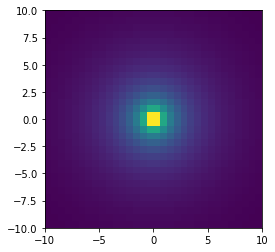

In [6]:
plt.pcolormesh(X, Y, sample_dm_emission(X, Y))
plt.gca().set_aspect("equal")
plt.xlim(-extent, extent)
plt.ylim(-extent, extent)

## Point sources

In [33]:
def _sample_ps_gc_helper(n: int):
    """
    Samples positions for point sources with the same spatial distribution as the
    DM emission.
    """
    rs = ps_gc_dist.sample((n,))
    angles = torch.rand(n) * 2 * pi
    xs = rs * torch.cos(angles)
    ys = rs * torch.sin(angles)
    return xs, ys


def sample_ps_gc(n: int):
    """
    Samples positions of point sources correlated with the disk.
    """
    xs, ys = _sample_ps_gc_helper(n)
    while True:
        idx_oob = (xs.abs() > extent) | (ys.abs() > extent)
        n_oob = idx_oob.sum()
        if n_oob == 0:
            return xs, ys
        else:
            xs[idx_oob], ys[idx_oob] = _sample_disk_helper(n_oob)

(-10.0, 10.0)

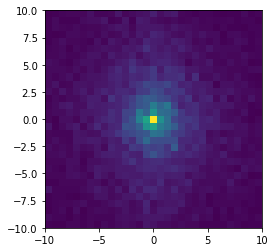

In [34]:
bins = torch.linspace(-extent, extent, 32)
res = torch.histogramdd(torch.stack(sample_ps_gc(10_000), 1), bins=(bins, bins))
plt.pcolormesh(bins, bins, res.hist)

plt.gca().set_aspect("equal")
plt.xlim(-extent, extent)
plt.ylim(-extent, extent)

In [35]:
def _sample_disk_helper(n: int, R_d=5, z_s=0.3):
    # Convert to degrees
    R_d = 5 / d_gc * 180 / pi
    z_s = z_s / d_gc * 180 / pi
    
    Rs = dist.Exponential(1 / R_d).sample((n,))
    ys = dist.Exponential(1 / z_s).sample((n,))
    
    # Randomly put pulsars above or below the galactic plane
    ys *= 2 * ((torch.rand(n) > 0.5).float() - 0.5)
    
    # Project radial coordinate
    angles = 2 * pi * torch.rand(n)
    xs = Rs * torch.cos(angles)
    
    return xs, ys


def sample_ps_disk(n: int, R_d=5, z_s=0.3):
    """
    Samples positions of point sources correlated with the disk.
    """
    xs, ys = _sample_disk_helper(n)
    while True:
        idx_oob = (xs.abs() > extent) | (ys.abs() > extent)
        n_oob = idx_oob.sum()
        if n_oob == 0:
            return xs, ys
        else:
            xs[idx_oob], ys[idx_oob] = _sample_disk_helper(n_oob)

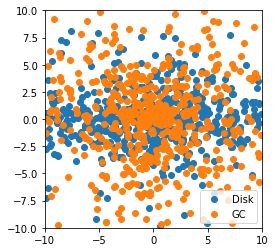

In [42]:
plt.scatter(*sample_ps_disk(500), label="Disk")
plt.scatter(*sample_ps_gc(500), label="GC")

plt.gca().set_aspect("equal")
plt.xlim(-extent, extent)
plt.ylim(-extent, extent)
plt.legend()

In [48]:
def _ps_photon_count_ucdf_low(s, n1, n2, n3, S_b1, S_b2):
    return (S_b2 / S_b1) ** (-n2) * S_b2**n3 * s ** (1 - n3) / (1 - n3)


def _ps_photon_count_ucdf_mid(s, n1, n2, n3, S_b1, S_b2):
    const = _ps_photon_count_ucdf_low(S_b2, n1, n2, n3, S_b1, S_b2)
    return const + S_b1**n2 * (s ** (1 - n2) - S_b2 ** (1 - n2)) / (1 - n2)


def _ps_photon_count_ucdf_high(s, n1, n2, n3, S_b1, S_b2):
    const = _ps_photon_count_ucdf_mid(S_b1, n1, n2, n3, S_b1, S_b2)
    return const + S_b1**n1 * (s ** (1 - n1) - S_b1 ** (1 - n1)) / (1 - n1)


def ps_photon_count_cdf(s, n1, n2, n3, S_b1, S_b2):
    return torch.where(
        s < S_b2,
        _ps_photon_count_ucdf_low(s, n1, n2, n3, S_b1, S_b2),
        torch.where(
            s < S_b1,
            _ps_photon_count_ucdf_mid(s, n1, n2, n3, S_b1, S_b2),
            _ps_photon_count_ucdf_high(s, n1, n2, n3, S_b1, S_b2),
        ),
    ) / _ps_photon_count_ucdf_high(10 * S_b1, n1, n2, n3, S_b1, S_b2)


def _ps_photon_count_iucdf_low(u, n1, n2, n3, S_b1, S_b2):
    a = (S_b2 / S_b1) ** (-n2) * S_b2**n3 / (1 - n3)
    return (u / a) ** (1 / (1 - n3))


def _ps_photon_count_iucdf_mid(u, n1, n2, n3, S_b1, S_b2):
    const = _ps_photon_count_ucdf_low(S_b2, n1, n2, n3, S_b1, S_b2)
    return ((u - const) / S_b1**n2 * (1 - n2) + S_b2 ** (1 - n2)) ** (1 / (1 - n2))


def _ps_photon_count_iucdf_high(u, n1, n2, n3, S_b1, S_b2):
    const = _ps_photon_count_ucdf_mid(S_b1, n1, n2, n3, S_b1, S_b2)
    return ((u - const) / S_b1**n1 * (1 - n1) + S_b1 ** (1 - n1)) ** (1 / (1 - n1))


def sample_ps_photon_counts(n: int, n1, n2, n3, S_b1, S_b2):
    """
    Samples photon counts for point sources.
    """
    u_thresh_low = _ps_photon_count_ucdf_low(S_b2, n1, n2, n3, S_b1, S_b2)
    u_thresh_mid = _ps_photon_count_ucdf_mid(S_b1, n1, n2, n3, S_b1, S_b2)
    # Easier to rescale u rather than normalizing the CDF
    norm = _ps_photon_count_ucdf_high(10 * S_b1, n1, n2, n3, S_b1, S_b2)
    us = torch.rand(n) * norm
    return torch.where(
        us < u_thresh_low,
        _ps_photon_count_iucdf_low(us, n1, n2, n3, S_b1, S_b2),
        torch.where(
            us < u_thresh_mid,
            _ps_photon_count_iucdf_mid(us, n1, n2, n3, S_b1, S_b2),
            _ps_photon_count_iucdf_high(us, n1, n2, n3, S_b1, S_b2),
        ),
    )


def ps_photon_count_mean(n1, n2, n3, S_b1, S_b2):
    """
    Mean photon count for point sources.
    """
    norm = _ps_photon_count_ucdf_high(10 * S_b1, n1, n2, n3, S_b1, S_b2)
    term_low = (S_b1 / S_b2)**n2 * S_b2**2 / (2 - n3)
    term_mid = S_b1**n2 / (2 - n2) * (S_b1**(2 - n2) - S_b2**(2 - n2))
    term_high = S_b1**n1 / (2 - n1) * (S_b1**(2 - n1))# - (10 * S_b1)**(2 - n2))
    return (
        term_low + term_mid + term_high
    ) / norm

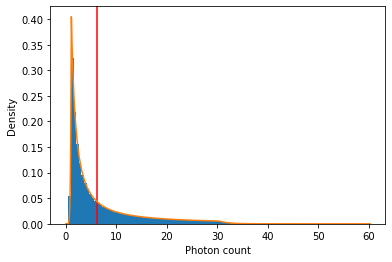

In [54]:
# Sample photon count distribution parameters
S_b1 = 35 * torch.rand(1) + 5
S_b2 = 4.89 * torch.rand(1) + 0.1
n1 = 10 * torch.rand(1) + 10
n2 = 0.89 * torch.rand(1) + 1.10
n3 = -10 * torch.rand(1)

# Sample photon counts
plt.hist(sample_ps_photon_counts(500_000, n1, n2, n3, S_b1, S_b2).numpy(), bins=100, density=True)

# Mean photon count per point source
plt.axvline(ps_photon_count_mean(n1, n2, n3, S_b1, S_b2), color="r")

# Plot PDF
Ss = torch.logspace(-2, log10(S_b1 * 2), 500)
plt.plot(Ss[1:], torch.diff(ps_photon_count_cdf(Ss, n1, n2, n3, S_b1, S_b2)) / torch.diff(Ss))

plt.xlabel("Photon count")
plt.ylabel("Density")

def sample_n_ps(n1, n2, n3, S_b1, S_b2):
    # Prior for mean photon count from point sources per pixel, see tab. 1.
    # This is based on 0.5 deg^2 pixels, so rescale to our pixel size.
    S_ps_mean = 2.5 * torch.rand(1) * resolution**2 / 0.5
    # Get mean number of point sources in the image
    rate = S_ps_mean / ps_photon_count_mean(n1, n2, n3, S_b1, S_b2) * n_pix**2
    # Sample the number of point sources
    return dist.Poisson(rate).sample()[0].int().item()

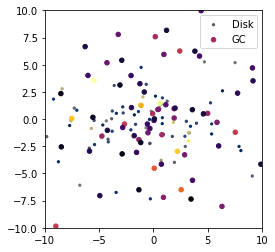

In [68]:
# Sample photon count distribution parameters
S_b1 = 35 * torch.rand(1) + 5
S_b2 = 4.89 * torch.rand(1) + 0.1
n1 = 10 * torch.rand(1) + 10
n2 = 0.89 * torch.rand(1) + 1.10
n3 = -10 * torch.rand(1)

n_ps = sample_n_ps(n1, n2, n3, S_b1, S_b2)
# Disk
xs_ps_disk, ys_ps_disk = sample_ps_disk(n_ps // 2)
counts_disk = sample_ps_photon_counts(n_ps // 2, n1, n2, n3, S_b1, S_b2)

xs_ps_gc, ys_ps_gc = sample_ps_gc(n_ps // 2)
counts_gc = sample_ps_photon_counts(n_ps // 2, n1, n2, n3, S_b1, S_b2)

plt.scatter(xs_ps_disk, ys_ps_disk, c=counts_disk, cmap="cividis", s=5, label="Disk")
plt.scatter(xs_ps_gc, ys_ps_gc, c=counts_gc, cmap="inferno", s=20, label="GC")

plt.gca().set_aspect("equal")
plt.xlim(-extent, extent)
plt.ylim(-extent, extent)
plt.legend()

In [80]:
dist.LogNormal(1.0, 1.0).sample((100_000,)).log().mean()

tensor(1.0001)

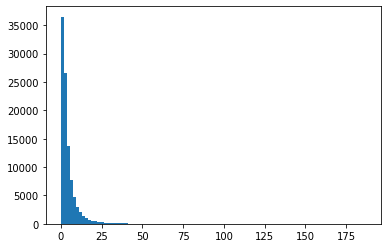

In [77]:
plt.hist(dist.LogNormal(1.0, 1.0).sample((100_000,)).numpy(), bins=100);

## Diffuse emission

In [485]:
class Diffuse:
    """
    This models diffuse gamma-ray emission. There are two components:
    - The gas-correlated component due to e.g. protons scattering inelastically with
      gas producing pions that decay to photons and bremsstrahlung from cosmic-ray
      electrons scattering off the gas. This exhibits structure on small scales.
      We label this 'brem_pi0'.
    - A component produced by inverse-Compton (IC) scattering of starlight and CMB
      photons by cosmic-ray electrons. This does not trace the gas distribution and
      does not have structure on small scales. We label this 'ic'.
    
    Modeling these in detail is extremely complex. The 'brem_pi0' component can be modeled
    by simulating gas maps, but this relies on various assumptions. Simulations of the
    interstellar radiation field and cosmic ray population can be used to estimate the 'ic'
    emission.
    
    To keep things simple but representative, we model 'brem_pi0' with a small-scale
    Gaussian process and 'ic' with a smooth distribution that falls off above and below
    the disk.
    
    References:
        - https://arxiv.org/abs/2002.12373, page 6
        - https://arxiv.org/abs/2112.09706, fig. 3
    """

    def __init__(self, A_brem_pi0=1, A_ic=30, sigma_brem_pi0=0.4, disk_height_ic=3):
        self.A_brem_pi0 = A_brem_pi0
        self.A_ic = A_ic
        self.sigma_brem_pi0 = sigma_brem_pi0
        self.disk_height_ic = disk_height_ic
    
    def sample_brem_pi0(self, d2s):
        # Take absolute value to avoid negative fluxes
        return sample_gp_prior(d2s, self.sigma_brem_pi0).abs()
    
    def sample_ic(self, Y):
        return torch.exp(-Y.abs() / self.disk_height_ic)
    
    def sample(self, Y, d2s):
        return self.A_brem_pi0 * self.sample_brem_pi0(d2s) + self.A_ic * self.sample_ic(Y)

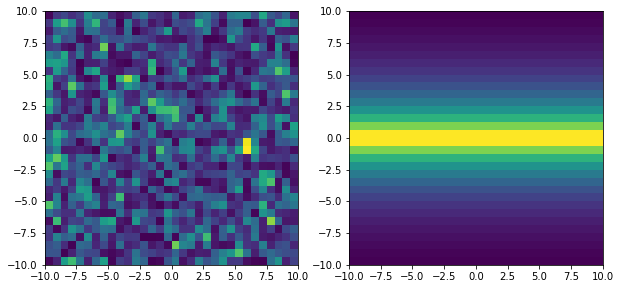

In [486]:
diff = Diffuse()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pcolormesh(X, Y, diff.sample_brem_pi0(d2s))
plt.gca().set_aspect("equal")

plt.subplot(1, 2, 2)
plt.pcolormesh(X, Y, diff.sample_ic(Y))
plt.gca().set_aspect("equal")

## Fermi bubbles

In [510]:
class FermiBubbles:
    """
    The Fermi bubbles are two giant lobes of cosmic ray emission extending above
    and below the galactic plane. Their extent is nearly that of the galaxy. Their
    origin is unknown, but possibly related to a burst of emission after an object fell
    into Sag A* (the black hole at the center of the Milky Way).

    We model the emission here as two large, smooth arcs covering the top and bottom
    of the image.

    References:
        - https://arxiv.org/abs/1901.03822 fig. 1 and sec. 2.5
    """
    smoothing_spatial_scale: float = 0.6  # deg

    def sample(self, X, Y, d2s):
        Y_norths = 10.5 * (torch.cosh((-X - 1) / 10.5) - 1) + 1
        Y_souths = -8.7 * (torch.cosh((-X + 1.7) / 8.7) - 1) - 1
        # Apply some hacky smoothing to the edges of the bubbles
        emission = torch.zeros(Y.shape)
        emission[Y > 0] = torch.sigmoid(
            (Y[Y > 0] - Y_norths[Y > 0]) / self.smoothing_spatial_scale
        )
        emission[Y < 0] = torch.sigmoid(
            (Y_souths[Y < 0] - Y[Y < 0]) / self.smoothing_spatial_scale
        )
        return emission

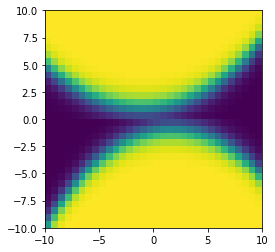

In [511]:
plt.pcolormesh(X, Y, FermiBubbles().sample(X, Y, d2s))
plt.gca().set_aspect("equal")

# Simulator

In [12]:
import swyft.lightning.components_v2 as sl

In [45]:
sim.resolution

0.46875

In [95]:
from functools import lru_cache


class Simulator(sl.SwyftSimulator):
    extent: float = 15  # observation size [deg]
    n_pix: int = 64
    d_gc: float = 8.3
    """Distance to galactic center [kpc]."""

    sigma_pi0: float = 0.25
    """Length scale associated with spatial variations in pi0 emission [deg]."""

    pi0_disk_height: float = 5.0
    """Disk height for pi0 emission"""

    pi0_disk_radius: float = 20.0
    """Disk radius for pi0 emission"""

    disk_height_ic: float = 5.0
    """Disk height for IC emission [deg]."""

    bubble_smoothing_scale: float = 0.6
    """Smoothing scale for Fermi bubble template [deg]."""

    ps_disk_height: float = 0.3
    """Disk scale height for disk-correlated point sources [kpc]."""

    ps_disk_radius: float = 5.0
    """Disk scale radius for disk-correlated point sources [kpc]."""

    dm_dist_concentration: float = 0.5
    """Steepness of DM emission."""

    dm_dist_scale: float = 5.0
    """Spatial scale of DM emission [deg]."""

    containment_radius: float = 0.8 / 3
    """Very approximate 68% containment radius for PSF [deg]."""

    @property
    def resolution(self):
        return 2 * self.extent / self.n_pix

    @property
    @lru_cache(maxsize=1)
    def XY(self):
        return get_meshgrid(self.resolution, self.n_pix, self.n_pix)

    @property
    def X(self):
        return self.XY[0]

    @property
    def Y(self):
        return self.XY[1]

    @property
    @lru_cache(maxsize=1)
    def kernel_pi0(self):
        pts = torch.stack([self.X.flatten(), self.Y.flatten()])
        d2s = ((pts[:, :, None] - pts[:, None, :]) ** 2).sum(0)
        return (-d2s / (2 * self.sigma_pi0**2)).exp()

    @property
    @lru_cache(maxsize=1)
    def psf_kernel(self):
        X_k, Y_k = get_meshgrid(self.resolution, 5, 5)
        kernel = torch.exp(-(X_k**2 + Y_k**2) / (2 * self.containment_radius**2))
        return kernel / kernel.sum()

    def sample_pi0(self):
        # Manually rescale to make it look more realistic
        emission = (self.kernel_pi0 @ torch.randn(self.n_pix**2)).reshape(
            self.n_pix, self.n_pix
        )
        emission = 50 * torch.exp(emission / 8)
        return (
            emission
            * torch.exp(-((self.X / self.pi0_disk_radius) ** 2))
            * torch.exp(-((self.Y / self.pi0_disk_height) ** 2))
        )

    def emission_ic(self):
        return 25 * torch.exp(-self.Y.abs() / self.disk_height_ic)

    def emission_bubbles(self):
        Y_norths = 10.5 * (torch.cosh((-self.X - 1) / 10.5) - 1) + 1
        Y_souths = -8.7 * (torch.cosh((-self.X + 1.7) / 8.7) - 1) - 1
        # Apply some hacky smoothing to the edges of the bubbles
        emission = torch.zeros([self.n_pix, self.n_pix])
        emission[self.Y > 0] = torch.sigmoid(
            (self.Y[self.Y > 0] - Y_norths[self.Y > 0]) / self.bubble_smoothing_scale
        )
        emission[self.Y < 0] = torch.sigmoid(
            (Y_souths[self.Y < 0] - self.Y[self.Y < 0]) / self.bubble_smoothing_scale
        )
        return 3 * emission

    def emission_dm(self):
        """
        Computes smooth emission from DM annihilation.
        """
        dm_dist = dist.Gamma(self.dm_dist_concentration, 1 / self.dm_dist_scale)
        # Distance to galactic center
        rs = torch.sqrt(self.X**2 + self.Y**2)
        return 100 * dm_dist.log_prob(rs).exp()

    def _sample_ps_gc_helper(self, n: int):
        # Use same distribution as for DM emission
        ps_gc_dist = dist.Gamma(self.dm_dist_concentration + 1, 1 / self.dm_dist_scale)
        rs = ps_gc_dist.sample((n,))
        angles = torch.rand(n) * 2 * pi
        xs = rs * torch.cos(angles)
        ys = rs * torch.sin(angles)
        return xs, ys

    def _sample_ps_disk_helper(self, n: int):
        # Convert to degrees
        scale_radius = self.ps_disk_radius / self.d_gc * 180 / pi
        scale_height = self.ps_disk_height / self.d_gc * 180 / pi

        rs = dist.Exponential(1 / scale_radius).sample((n,))
        ys = dist.Exponential(1 / scale_height).sample((n,))

        # Randomly put pulsars above or below the galactic plane
        ys *= 2 * ((torch.rand(n) > 0.5).float() - 0.5)

        # Project radial coordinate
        angles = 2 * pi * torch.rand(n)
        xs = rs * torch.cos(angles)

        return xs, ys

    def _generate_pss(self, n: int, pos_sampler, ps_log_flux_mean, ps_log_flux_scale):
        """
        Generates a pixelated map with randomly-sampled point sources.
        """
        # Sample fluxes
        fluxes = dist.LogNormal(ps_log_flux_mean, ps_log_flux_scale).sample((n,))

        # Sample positions
        xs, ys = pos_sampler(n)
        while True:
            idx_oob = (xs.abs() > self.extent) | (ys.abs() > self.extent)
            n_oob = idx_oob.sum()
            if n_oob == 0:
                break
            else:
                xs[idx_oob], ys[idx_oob] = pos_sampler(n_oob)

        # Map onto pixel grid
        bins = torch.linspace(-self.extent, self.extent, self.n_pix + 1)
        return torch.histogramdd(
            torch.stack([ys, xs], 1), bins=(bins, bins), weight=fluxes
        ).hist

    def sample_ps_gc(self, n: int, ps_log_flux_mean, ps_log_flux_scale):
        """
        Samples point sources with the same spatial distribution as the DM emission.
        """
        return self._generate_pss(
            n, self._sample_ps_gc_helper, ps_log_flux_mean, ps_log_flux_scale
        )

    def sample_ps_disk(self, n: int, ps_log_flux_mean, ps_log_flux_scale):
        """
        Samples point sources correlated with the disk.
        """
        return self._generate_pss(
            n, self._sample_ps_disk_helper, ps_log_flux_mean, ps_log_flux_scale
        )

    def forward(self, trace: sl.SwyftTrace) -> Tensor:
        A_ic = trace.record("A_ic", torch.rand, 1)
        A_pi0 = trace.record("A_pi0", torch.rand, 1)
        A_bubbles = trace.record("A_bubbles", torch.rand, 1)
        A_dm = trace.record("A_dm", torch.rand, 1)
        n_ps_gc = trace.record("n_ps_gc", torch.randint, low=200, high=800, size=(1,))
        n_ps_disk = trace.record(
            "n_ps_disk", torch.randint, low=1000, high=4000, size=(1,)
        )
        ps_log_flux_mean = 1.0
        ps_log_flux_scale = 1.2

        # Mean emission
        mu = trace.record(
            "mu",
            lambda A_ic, A_pi0, A_dm, A_bubbles, n_ps_disk: (
                A_ic * self.emission_ic()
                + A_pi0 * self.sample_pi0()
                + A_dm * self.emission_dm()
                + A_bubbles * self.emission_bubbles()
                + self.sample_ps_gc(n_ps_gc, ps_log_flux_mean, ps_log_flux_scale)
                + self.sample_ps_disk(n_ps_disk, ps_log_flux_mean, ps_log_flux_scale)
            ),
            A_ic,
            A_pi0,
            A_dm,
            A_bubbles,
            n_ps_disk,
        )

        # Convolve with PSF and add noise (TODO)
        obs = trace.record(
            "obs",
            lambda mu: dist.Poisson(
                torch.nn.functional.conv2d(
                    mu[None, None, :, :],
                    self.psf_kernel[None, None, :, :],
                    padding=2,
                )[0, 0, :, :]
            ).sample(),
            mu
        )

In [96]:
sim = Simulator()

GC PS: 0.42397546768188477
Disk PS: 2.331003189086914
pi0: 12.529806137084961
IC: 7.9155426025390625
Bubbles: 1.9019166231155396
DM: 1.5946274995803833


100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 164.23it/s]


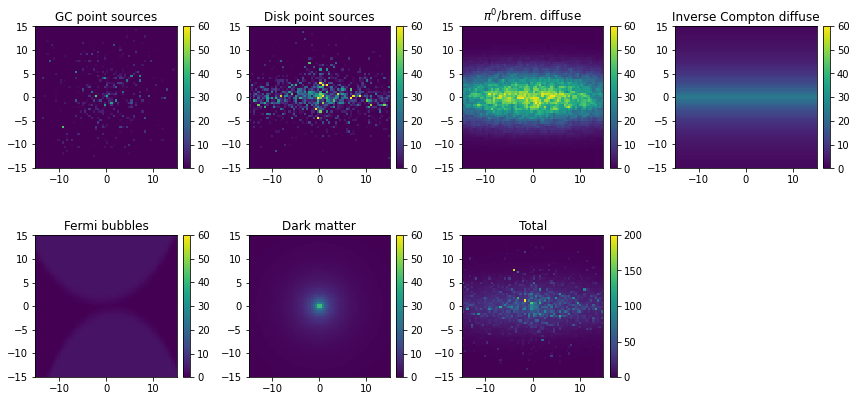

In [113]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

ax = axes[0, 0]
hist = sim.sample_ps_gc(400, 1.0, 1.0)
im = ax.pcolormesh(sim.X, sim.Y, hist, vmin=0, vmax=60)
print("GC PS:", hist.mean().item())
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("GC point sources")

ax = axes[0, 1]
hist = sim.sample_ps_disk(2000, 1.0, 1.0)
im = ax.pcolormesh(sim.X, sim.Y, hist, vmin=0, vmax=60)
print("Disk PS:", hist.mean().item())
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Disk point sources")

ax = axes[0, 2]
im = ax.pcolormesh(sim.X, sim.Y, sim.sample_pi0(), vmin=0, vmax=60)
print("pi0:", sim.sample_pi0().mean().item())
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title(r"$\pi^0$/brem. diffuse")

ax = axes[0, 3]
im = ax.pcolormesh(sim.X, sim.Y, sim.emission_ic(), vmin=0, vmax=60)
print("IC:", sim.emission_ic().mean().item())
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Inverse Compton diffuse")

ax = axes[1, 0]
im = ax.pcolormesh(sim.X, sim.Y, sim.emission_bubbles(), vmin=0, vmax=60)
print("Bubbles:", sim.emission_bubbles().mean().item())
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Fermi bubbles")

ax = axes[1, 1]
im = ax.pcolormesh(sim.X, sim.Y, sim.emission_dm(), vmin=0, vmax=60)
print("DM:", sim.emission_dm().mean().item())
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Dark matter")

ax = axes[1, 2]
im = ax.pcolormesh(sim.X, sim.Y, sim.sample(1)[0]["mu"], vmin=0, vmax=200)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Total")

axes[1, 3].axis("off")

for ax in axes.flatten():
    ax.set_aspect("equal")

fig.tight_layout()

100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.53it/s]


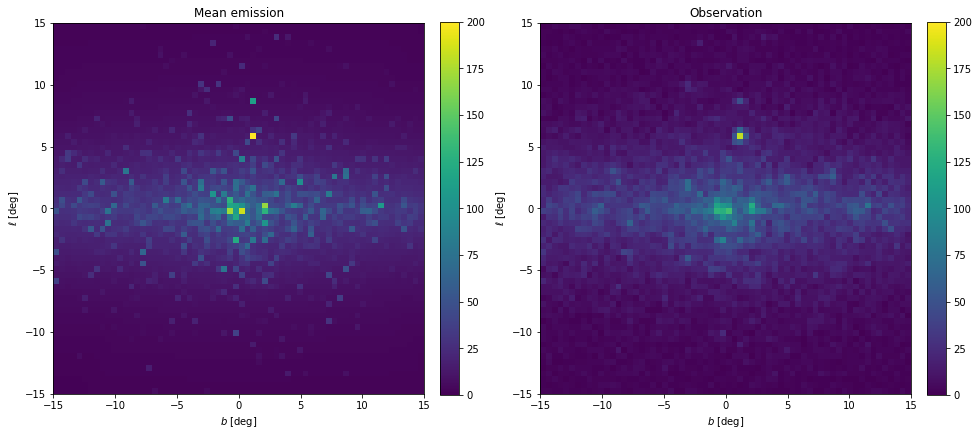

In [126]:
observation = sim.sample(1)[0]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

ax = axs[0]
im = ax.pcolormesh(sim.X, sim.Y, observation["mu"], vmin=0, vmax=200)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Mean emission")

ax = axs[1]
im = ax.pcolormesh(sim.X, sim.Y, observation["obs"], vmin=0, vmax=200)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Observation")

for ax in axs:
    ax.set_aspect("equal")
    ax.set_xlabel(r"$b$ [deg]")
    ax.set_ylabel(r"$\ell$ [deg]")